<a href="https://colab.research.google.com/github/Cosmox999/SOC-RL/blob/main/Monte_carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy==1.23.5 gym==0.25.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 80.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode: 0, Reward: 0.0, Epsilon: 1.00
Episode: 1000, Reward: 0.0, Epsilon: 0.37
Episode: 2000, Reward: 1.0, Epsilon: 0.14
Episode: 3000, Reward: 1.0, Epsilon: 0.05
Episode: 4000, Reward: 1.0, Epsilon: 0.02
Episode: 5000, Reward: 1.0, Epsilon: 0.01
Episode: 6000, Reward: 1.0, Epsilon: 0.01
Episode: 7000, Reward: 1.0, Epsilon: 0.01
Episode: 8000, Reward: 1.0, Epsilon: 0.01
Episode: 9000, Reward: 1.0, Epsilon: 0.01


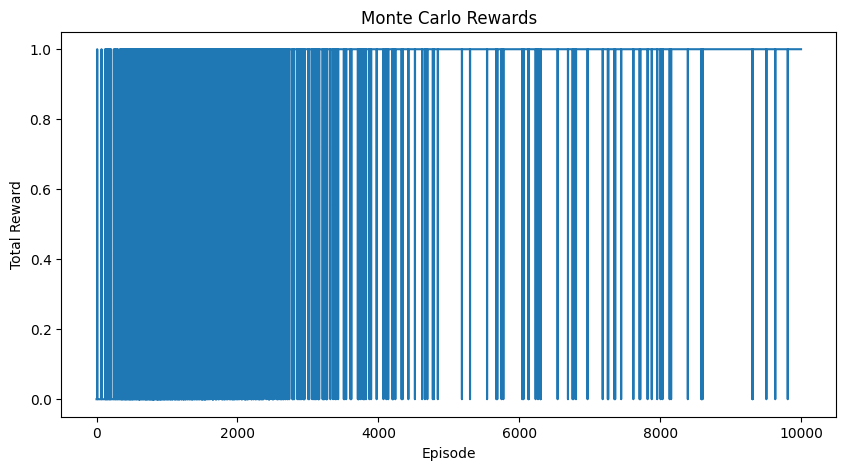

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def generate_episode(env, policy, epsilon):
    episode = []
    state = env.reset()
    if isinstance(state, tuple):  # Handle newer Gym versions
        state = state[0]
    done = False

    while not done:
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = policy[state]

        result = env.step(action)
        if len(result) == 4:  # Older Gym versions
            next_state, reward, done, _ = result
        else:  # Newer Gym versions
            next_state, reward, terminated, truncated, _ = result
            done = terminated or truncated

        episode.append((state, action, reward))
        state = next_state

    return episode

def train_monte_carlo(env, episodes=10000, gamma=0.99, epsilon=1.0, min_epsilon=0.01, decay=0.999):
    # Initialize Q as numpy array instead of defaultdict
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    N = np.zeros((env.observation_space.n, env.action_space.n))
    policy = np.zeros(env.observation_space.n, dtype=int)
    rewards = []

    for episode in range(episodes):
        # Generate episode
        episode_data = generate_episode(env, policy, epsilon)
        states, actions, ep_rewards = zip(*episode_data)
        total_reward = sum(ep_rewards)
        rewards.append(total_reward)

        # Calculate returns and update Q
        G = 0
        visited = set()

        for t in range(len(episode_data)-1, -1, -1):
            state, action, reward = episode_data[t]
            G = gamma * G + reward

            # First-visit MC
            if (state, action) not in visited:
                visited.add((state, action))
                N[state][action] += 1
                Q[state][action] += (G - Q[state][action]) / N[state][action]
                policy[state] = np.argmax(Q[state])

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * decay)

        if episode % 1000 == 0:
            print(f"Episode: {episode}, Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    return Q, policy, rewards

def plot_rewards(rewards, title="Monte Carlo Rewards"):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.savefig("monte_carlo_rewards.png")
    plt.show()

if __name__ == "__main__":
    # Create environment with new API
    env = gym.make('FrozenLake-v1', is_slippery=False, render_mode='rgb_array')

    # Train the agent
    Q, policy, rewards = train_monte_carlo(env)
    plot_rewards(rewards)

    # Save results
    np.save("monte_carlo_Q.npy", Q)
    np.save("monte_carlo_policy.npy", policy)

    # Record video
    from gym.wrappers import RecordVideo
    env.close()
    env = gym.make('FrozenLake-v1', is_slippery=False, render_mode='rgb_array')
    env = RecordVideo(env, "videos", name_prefix="monte_carlo")

    # Run one episode for recording
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    done = False

    while not done:
        action = policy[state]
        result = env.step(action)
        if len(result) == 4:
            next_state, _, done, _ = result
        else:
            next_state, _, terminated, truncated, _ = result
            done = terminated or truncated
        state = next_state

    env.close()